# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
import pandas as pd

df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw08_boosting_clustering/ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [ ]:
from sklearn.model_selection import train_test_split

y = df["salary_in_usd"]
X = df.drop(["salary_in_usd", "salary"], axis=1)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

Видимо, под удалением лика подразумевается удаление признака 'salary', так как как будто бы чисто по 'salary', 'work_year' и 'salary_currency' можно посчитать таргет (зная курсы валют по годам), а при 'salary_currency' == USD таргет вообще просто совпадает с 'salary'. Поэтому, судя по всему, требуется удалить 'salary'.

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import math

categorical_features = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", "company_location", "company_size"]
oh = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform="pandas").fit(X_train[categorical_features])
X_train_oh = oh.transform(X_train[categorical_features])
X_train = pd.concat([X_train, X_train_oh], axis=1).drop(columns=categorical_features)
X_val_oh = oh.transform(X_val[categorical_features])
X_val = pd.concat([X_val, X_val_oh], axis=1).drop(columns=categorical_features)
X_test_oh = oh.transform(X_test[categorical_features])
X_test = pd.concat([X_test, X_test_oh], axis=1).drop(columns=categorical_features)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test_ans = lr.predict(X_test)

print("MAPE: ", mean_absolute_percentage_error(y_test, y_test_ans))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_test_ans)))

MAPE:  5922424.34395404
RMSE:  1675369933662.5164


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import itertools

params = {
    'max_depth' : [10, 100, 1000, 10000],
    'learning_rate' : [0.01, 0.1, 1],
    'n_estimators' : [10, 100, 1000],
    'gamma' : [0.01, 0.2, 0.5, 0.99],
}
best_rmse = 1000000000000000000000000000
best_params = (-1, -1, -1, -1)
for max_depth, learning_rate, n_estimators, gamma in itertools.product(params["max_depth"], params["learning_rate"], params["n_estimators"], params["gamma"]):
    xgbr = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma, random_state=42)
    xgbr.fit(X_train, y_train)
    y_pred = xgbr.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, y_pred))
    print("max_depth:", max_depth, "learning_rate:", learning_rate, "n_estimators", n_estimators, "gamma", gamma, "RMSE:", rmse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (max_depth, learning_rate, n_estimators, gamma)
print("BEST PARAMS:", best_params)

max_depth: 10 learning_rate: 0.01 n_estimators 10 gamma 0.01 RMSE: 59021.04941016081
max_depth: 10 learning_rate: 0.01 n_estimators 10 gamma 0.2 RMSE: 59021.04941016081
max_depth: 10 learning_rate: 0.01 n_estimators 10 gamma 0.5 RMSE: 59021.04941016081
max_depth: 10 learning_rate: 0.01 n_estimators 10 gamma 0.99 RMSE: 59021.04941016081
max_depth: 10 learning_rate: 0.01 n_estimators 100 gamma 0.01 RMSE: 47907.85498763676
max_depth: 10 learning_rate: 0.01 n_estimators 100 gamma 0.2 RMSE: 47907.85498763676
max_depth: 10 learning_rate: 0.01 n_estimators 100 gamma 0.5 RMSE: 47907.85498763676
max_depth: 10 learning_rate: 0.01 n_estimators 100 gamma 0.99 RMSE: 47907.85498763676
max_depth: 10 learning_rate: 0.01 n_estimators 1000 gamma 0.01 RMSE: 45770.14497814654
max_depth: 10 learning_rate: 0.01 n_estimators 1000 gamma 0.2 RMSE: 45770.14497814654
max_depth: 10 learning_rate: 0.01 n_estimators 1000 gamma 0.5 RMSE: 45770.14497814654
max_depth: 10 learning_rate: 0.01 n_estimators 1000 gamma 0.9

In [ ]:
import time

xgbr = XGBRegressor(max_depth=best_params[0], learning_rate=best_params[1], n_estimators=best_params[2], gamma=best_params[3], random_state=42)
start = time.time()
xgbr.fit(X_train, y_train)
end = time.time()
print("TIME OF LEARNING:", end - start)
start = time.time()
y_pred = xgbr.predict(X_test)
end = time.time()
print("PREDICTION TIME:", end - start)
print("MAPE:", mean_absolute_percentage_error(y_pred, y_test))
print("RMSE:", math.sqrt(mean_squared_error(y_pred, y_test)))

TIME OF LEARNING: 6.6159303188323975
PREDICTION TIME: 0.08057498931884766
MAPE: 0.2823696375192756
RMSE: 51477.22903282361


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from catboost import CatBoostRegressor

params = {
    'depth' : [2, 4, 8, 16],
    'learning_rate' : [0.01, 0.1, 1],
    'iterations' : [10, 100, 1000]
}

best_rmse = 1000000000000000000000000000
best_params = (-1, -1, -1, -1)
for depth, learning_rate, iterations in itertools.product(params["depth"], params["learning_rate"], params["iterations"]):
    cbr = CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, random_state=42)
    cbr.fit(X_train, y_train)
    y_pred = cbr.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, y_pred))
    print("depth:", depth, "learning_rate:", learning_rate, "iterations", iterations, "RMSE:", rmse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (depth, learning_rate, iterations)
print("BEST PARAMS:", best_params)

0:	learn: 62921.1661723	total: 1.83ms	remaining: 16.5ms
1:	learn: 62743.5532595	total: 4.7ms	remaining: 18.8ms
2:	learn: 62588.9136027	total: 6.51ms	remaining: 15.2ms
3:	learn: 62429.2534900	total: 8.36ms	remaining: 12.5ms
4:	learn: 62259.3553521	total: 10.2ms	remaining: 10.2ms
5:	learn: 62104.7298130	total: 12ms	remaining: 8.02ms
6:	learn: 61952.7722110	total: 14.1ms	remaining: 6.05ms
7:	learn: 61797.7374710	total: 16.2ms	remaining: 4.04ms
8:	learn: 61650.1243504	total: 18.3ms	remaining: 2.03ms
9:	learn: 61502.0052571	total: 20.2ms	remaining: 0us
depth: 2 learning_rate: 0.01 iterations 10 RMSE: 59928.763420254945
0:	learn: 62921.1661723	total: 1.91ms	remaining: 189ms
1:	learn: 62743.5532595	total: 4.03ms	remaining: 198ms
2:	learn: 62588.9136027	total: 6.26ms	remaining: 202ms
3:	learn: 62429.2534900	total: 8.51ms	remaining: 204ms
4:	learn: 62259.3553521	total: 11.4ms	remaining: 217ms
5:	learn: 62104.7298130	total: 13.4ms	remaining: 210ms
6:	learn: 61952.7722110	total: 15.4ms	remaining:

In [ ]:
cbr = CatBoostRegressor(depth=best_params[0], learning_rate=best_params[1], iterations=best_params[2], random_state=42)
start = time.time()
cbr.fit(X_train, y_train)
end = time.time()
print("TIME OF LEARNING:", end - start)
start = time.time()
y_pred = cbr.predict(X_test)
end = time.time()
print("PREDICTION TIME:", end - start)
print("MAPE:", mean_absolute_percentage_error(y_pred, y_test))
print("RMSE:", math.sqrt(mean_squared_error(y_pred, y_test)))

0:	learn: 61137.8131156	total: 6.47ms	remaining: 6.46s
1:	learn: 59717.4094388	total: 21.8ms	remaining: 10.9s
2:	learn: 58436.8064315	total: 36.6ms	remaining: 12.1s
3:	learn: 56968.8068568	total: 52.8ms	remaining: 13.1s
4:	learn: 55981.8496928	total: 67.2ms	remaining: 13.4s
5:	learn: 54990.8969328	total: 82.1ms	remaining: 13.6s
6:	learn: 54300.0469499	total: 97.6ms	remaining: 13.8s
7:	learn: 53559.0099968	total: 113ms	remaining: 14s
8:	learn: 52840.0995522	total: 129ms	remaining: 14.2s
9:	learn: 52356.6425591	total: 144ms	remaining: 14.3s
10:	learn: 51906.4891687	total: 159ms	remaining: 14.3s
11:	learn: 51532.5934937	total: 175ms	remaining: 14.4s
12:	learn: 51208.3936585	total: 207ms	remaining: 15.8s
13:	learn: 50950.0317994	total: 223ms	remaining: 15.7s
14:	learn: 50774.8983768	total: 238ms	remaining: 15.6s
15:	learn: 50511.7285525	total: 255ms	remaining: 15.7s
16:	learn: 50360.5181528	total: 271ms	remaining: 15.7s
17:	learn: 50159.8619917	total: 286ms	remaining: 15.6s
18:	learn: 5005

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from catboost import Pool

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

pool = Pool(X_train, y_train, cat_features=categorical_features, feature_names=list(X.columns))
params = {
    'depth' : [2, 4, 8],
    'learning_rate' : [0.01, 0.1, 1],
    'iterations' : [10, 100, 1000]
}

best_rmse = 1000000000000000000000000000
best_params = (-1, -1, -1, -1)
for depth, learning_rate, iterations in itertools.product(params["depth"], params["learning_rate"], params["iterations"]):
    cbr = CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, random_state=42)
    cbr.fit(pool)
    y_pred = cbr.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, y_pred))
    print("depth:", depth, "learning_rate:", learning_rate, "iterations", iterations, "RMSE:", rmse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (depth, learning_rate, iterations)
print("BEST PARAMS:", best_params)

0:	learn: 62908.9482120	total: 10.7ms	remaining: 96ms
1:	learn: 62731.1504795	total: 27.1ms	remaining: 108ms
2:	learn: 62554.7562007	total: 42.3ms	remaining: 98.6ms
3:	learn: 62381.0820459	total: 58.9ms	remaining: 88.4ms
4:	learn: 62209.9775270	total: 75.9ms	remaining: 75.9ms
5:	learn: 62045.6945348	total: 92ms	remaining: 61.4ms
6:	learn: 61883.4416157	total: 108ms	remaining: 46.3ms
7:	learn: 61721.1689859	total: 125ms	remaining: 31.2ms
8:	learn: 61561.8354868	total: 143ms	remaining: 15.9ms
9:	learn: 61407.8057819	total: 159ms	remaining: 0us
depth: 2 learning_rate: 0.01 iterations 10 RMSE: 59799.38088140852
0:	learn: 62908.9482120	total: 10.4ms	remaining: 1.03s
1:	learn: 62731.1504795	total: 27.7ms	remaining: 1.35s
2:	learn: 62554.7562007	total: 41.1ms	remaining: 1.33s
3:	learn: 62381.0820459	total: 55ms	remaining: 1.32s
4:	learn: 62209.9775270	total: 68.7ms	remaining: 1.3s
5:	learn: 62045.6945348	total: 82.5ms	remaining: 1.29s
6:	learn: 61883.4416157	total: 97.3ms	remaining: 1.29s
7:	

In [ ]:
cbr = CatBoostRegressor(depth=best_params[0], learning_rate=best_params[1], iterations=best_params[2], random_state=42)
start = time.time()
cbr.fit(pool)
end = time.time()
print("TIME OF LEARNING:", end - start)
start = time.time()
y_pred = cbr.predict(X_test)
end = time.time()
print("PREDICTION TIME:", end - start)
print("MAPE:", mean_absolute_percentage_error(y_pred, y_test))
print("RMSE:", math.sqrt(mean_squared_error(y_pred, y_test)))

0:	learn: 62908.9482120	total: 29.9ms	remaining: 29.9s
1:	learn: 62715.2024348	total: 57.9ms	remaining: 28.9s
2:	learn: 62531.0142014	total: 86.8ms	remaining: 28.9s
3:	learn: 62350.2650191	total: 112ms	remaining: 27.8s
4:	learn: 62177.0963805	total: 137ms	remaining: 27.3s
5:	learn: 62003.8253340	total: 181ms	remaining: 30.1s
6:	learn: 61830.5848326	total: 208ms	remaining: 29.5s
7:	learn: 61662.5467054	total: 234ms	remaining: 29s
8:	learn: 61493.5702025	total: 260ms	remaining: 28.7s
9:	learn: 61326.2946648	total: 289ms	remaining: 28.7s
10:	learn: 61156.0351504	total: 321ms	remaining: 28.8s
11:	learn: 60999.1885416	total: 346ms	remaining: 28.4s
12:	learn: 60840.7984451	total: 370ms	remaining: 28.1s
13:	learn: 60694.9129145	total: 396ms	remaining: 27.9s
14:	learn: 60538.3230472	total: 422ms	remaining: 27.7s
15:	learn: 60386.6990591	total: 444ms	remaining: 27.3s
16:	learn: 60249.8193984	total: 468ms	remaining: 27.1s
17:	learn: 60106.0843766	total: 493ms	remaining: 26.9s
18:	learn: 59959.97

**Ответ:** CatBoost показал себя лучше, чем XGBoost, вероятно, потому что в датасете много категориальных признаков, и именно на них CatBoost хорошо работает. С pool'ом CatBoost показал себя незначительно лучше по RMSE и чуть хуже по MAPE. По времени примерно одинаково.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


Придётся снова заванхотэнкодить X, так как я его переопределил в предыдущем задании, а пересчитывать времени нет

In [ ]:
categorical_features = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", "company_location", "company_size"]
oh = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform="pandas").fit(X_train[categorical_features])
X_train_oh = oh.transform(X_train[categorical_features])
X_train = pd.concat([X_train, X_train_oh], axis=1).drop(columns=categorical_features)
X_val_oh = oh.transform(X_val[categorical_features])
X_val = pd.concat([X_val, X_val_oh], axis=1).drop(columns=categorical_features)
X_test_oh = oh.transform(X_test[categorical_features])
X_test = pd.concat([X_test, X_test_oh], axis=1).drop(columns=categorical_features)

In [ ]:
from lightgbm import LGBMRegressor


params = {
    'max_depth' : [10, 100, 1000, 10000],
    'learning_rate' : [0.01, 0.1, 1],
    'n_estimators' : [10, 100, 1000]
}

best_rmse = 1000000000000000000000000000
best_params = (-1, -1, -1, -1)
for max_depth, learning_rate, n_estimators in itertools.product(params["max_depth"], params["learning_rate"], params["n_estimators"]):
    cbr = LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
    cbr.fit(X_train, y_train)
    y_pred = cbr.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, y_pred))
    print("depth:", max_depth, "learning_rate:", learning_rate, "n_estimators", n_estimators, "RMSE:", rmse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (max_depth, learning_rate, n_estimators)
print("BEST PARAMS:", best_params)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 41
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
depth: 10 learning_rate: 0.01 n_estimators 10 RMSE: 59045.38418906083
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (nu

In [ ]:
lgbmr = LGBMRegressor(max_depth=best_params[0], learning_rate=best_params[1], n_estimators=best_params[2], random_state=42)
start = time.time()
lgbmr.fit(X_train, y_train)
end = time.time()
print("TIME OF LEARNING:", end - start)
start = time.time()
y_pred = lgbmr.predict(X_test)
end = time.time()
print("PREDICTION TIME:", end - start)
print("MAPE:", mean_absolute_percentage_error(y_pred, y_test))
print("RMSE:", math.sqrt(mean_squared_error(y_pred, y_test)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 41
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** Лучше всего себя показала LGBMRegression по всему: по времени обучения, по MAPE, и по RMSE. По времени получилось хорошо, так как в датасете много категориальных признаков. LGBM не кодирует их, а использует исходные категории для получения предикатов. Также ускорение и хорошее качество LGBM достигается за счёт бинаризации признаков и полиственного построения деревьев. Сравнивая по времени XGBoost и CatBoost можно заметить, что XGBoost быстрее обучается, в то время как CatBoost быстрее остальных моделей (даже быстрее LGBM) делает предсказания. Это происходит потому, что CatBoost с одной стороны устойчив к переобучению (используются симметричные деревья и динамический бустинг, т. е. обучение сложнее и дольше, чем в других моделях), но с другой стороны может использовать много разных методов для кодирования категориальных признаков, поэтому именно с категориальными признаками (которых в датасете много) он и должен работать быстрее. По RMSE XGBoost и CatBoost показали себя примерно одинаково. Гиперпараметры моделей по большому счёту не отличаются в пределах погрешности (ведь сетка перебора параметров крупная, иначе слишком долго считается). Единственное сильное отличие - у CatBoost маленькая максимальныя глубина деревьев (программно она вообще не может быть больше 16).

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [111]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/raw/main/datasets/sample_matrix.xlsx", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [112]:
ratingsT = ratings.T
ratingsT

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [113]:
ratingsT = ratingsT.drop(["user"])

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [114]:
ratingsT = ratingsT.fillna(0)
ratingsT.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
fear factory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
ratings = ratingsT
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
deftones,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071995,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [116]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = 5, random_state=42)
k_means = k_means.fit(ratings)
clusters = k_means.predict(ratings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [117]:
pd.value_counts(clusters)

2    995
0      2
3      1
4      1
1      1
Name: count, dtype: int64

**Ответ:** Такая себе кластеризация: в один кластер попали 995 объектов, а остальные 5 - в другие 4 кластера. В kmeans важна случайность: важно, откуда мы начинаем, не гарантируется оптимальное разбиение на кластеры (условно ищестя локальный минимум суммарного отклонения всех точек от центров кластеров, а не глобальный). Поэтому результат может отличаться от правильной кластеризации.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

В моём случае это кластеры 3, 4, 1.

In [118]:
index = (clusters == 3) | (clusters == 4) | (clusters == 1)
ratings.index[index]

Index(['the beatles', 'coldplay', '보아'], dtype='object')

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

Доля слушающих

In [119]:
cols = ratings.columns
1 - ratings[cols].eq(0).sum(axis=1) / ratings.shape[1]

the beatles           0.3342
radiohead             0.2778
deathcab for cutie    0.1862
coldplay              0.1682
modest mouse          0.1628
                       ...  
michal w. smith       0.0094
群星                    0.0094
agalloch              0.0094
meshuggah             0.0094
yellowcard            0.0094
Length: 1000, dtype: float64

Средняя доля прослушивания

In [136]:
ratings.mean(axis=1)

the beatles           0.018369
radiohead             0.011851
deathcab for cutie    0.006543
coldplay              0.006030
modest mouse          0.005876
                        ...   
michal w. smith       0.000895
群星                    0.000519
agalloch              0.000997
meshuggah             0.000431
yellowcard            0.000320
Length: 1000, dtype: float64

**Ответ:** Можно заметить, что the beatles выделается в обоих случаях как самая популярная группа, потому она даже выделилась в свой кластер



## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [137]:
from sklearn.preprocessing import normalize

nratings = normalize(ratings)
k_means = KMeans(n_clusters = 5, random_state=42)
k_means = k_means.fit(nratings)
nratingspd = pd.DataFrame(nratings, index=ratings.index)
clusters = k_means.predict(nratings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [138]:
pd.value_counts(clusters)

2    405
0    237
1    152
3    139
4     67
Name: count, dtype: int64

**Ответ** Кластеризация более полезна, чем в прошлый раз, ведь размеры кластеров не так сильно отличаются, и нет кластеров размером 1. Хотя без визуализации трудно наверняка, что стало сильно лучше.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [146]:
from scipy.spatial.distance import cosine
import numpy as np

centroids = k_means.cluster_centers_

for c in centroids:
    nratingspd["d"] = np.array([cosine(c, row) for row in nratings])
    print(nratingspd.sort_values("d")[:10].index)
nratingspd = nratingspd.drop(["d"], axis=1)

Index(['radiohead', 'the arcade fire', 'broken social scene',
       'animal collective', 'belle and sebastian', 'sufjan stevens',
       'the shins', 'of montreal', 'the pixies', 'spoon'],
      dtype='object')
Index(['kelly clarkson', 'rihanna & jay-z', 'maroon5', 'the pussycat dolls',
       'john mayer', 'alicia keys', 'lady gaga', 'beyoncé', 'coldplay',
       'nelly furtado'],
      dtype='object')
Index(['the beatles', 'the rolling stones', 'led zeppelin.', 'pink fluid',
       'acdc', 'metallica', 'radiohead', 'red hot clili peppers', 'the clash',
       'queen'],
      dtype='object')
Index(['fall out boy', 'saosin', 'brand new', 'taking back sunday',
       'blink-182', 'anberlin', 'the used', 'cartel', 'chiodos',
       'new found glory'],
      dtype='object')
Index(['nas', 'jay-z', 'a tribe called quest', 'kanye west',
       'the roots featuring d'angelo', 'lupe the gorilla', 'gangstarr',
       'murs and 9th wonder', 'little brother', 'mos def'],
      dtype='object')


**Ответ:** Не могу назвать себя человеком, разбирающимся в этих музыкальных группах, но, полагаю, в кластерах исполнители объединены по жанру музыки/инструментам, на которых играют исполнители. Единственный интересный кластер - ['the beatles', 'the rolling stones', 'led zeppelin.', 'pink fluid',
       'acdc', 'metallica', 'radiohead', 'red hot clili peppers', 'the clash',
       'queen'], который содержит наиболее популярные группы среди всех слушателей

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

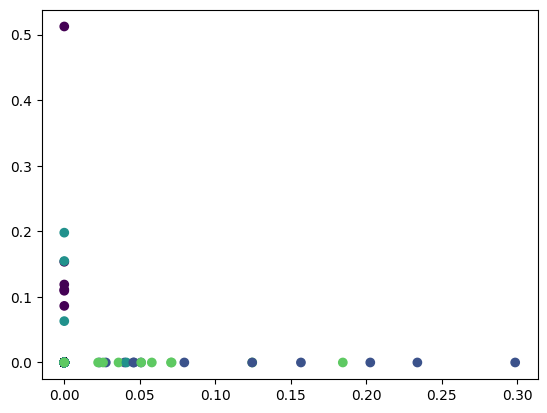

In [157]:
import matplotlib.pyplot as plt

plt.scatter(nratingspd[41], nratingspd[1336], c=clusters)

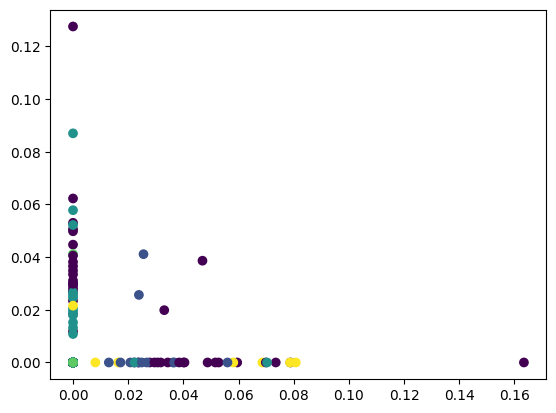

In [158]:
plt.scatter(nratingspd[1487], nratingspd[419], c=clusters)

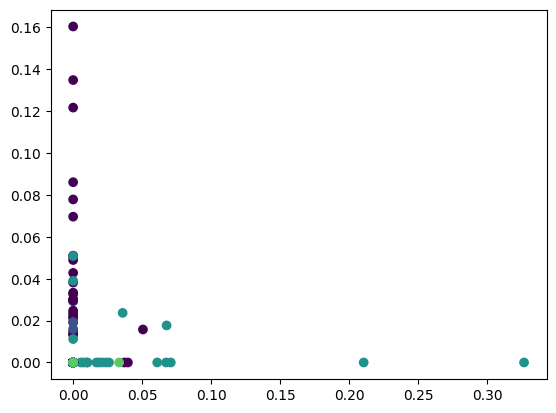

In [159]:
plt.scatter(nratingspd[68], nratingspd[992], c=clusters)

**Ответ:** Нет, визуализация плоха, так как размерность для вищуализации слишком маленькая: почти во всех строках либо один, либо другой признак нулевой, а в подавляющем большинстве строк - оба признака равны 0. Это не даёт нам интерпретируемой картины распределения по группам с геометрической точки зрения.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

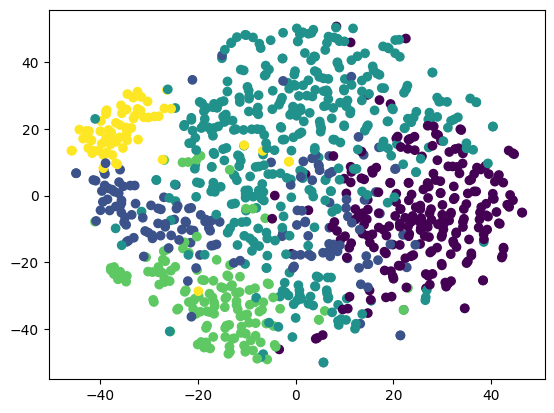

In [165]:
from sklearn.manifold import TSNE

tnse = TSNE(n_components=2, random_state=42)
tnse_relust = tnse.fit_transform(nratingspd)
plt.scatter(tnse_relust[:, 0], tnse_relust[:, 1], c=clusters)

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [175]:
from sklearn.metrics import silhouette_score

best_ss = 0
best_n_of_clusters = -1
for noclusters in range(2, 10):
    k_means = KMeans(n_clusters=noclusters, random_state=42)
    curr_ss = silhouette_score(nratingspd, k_means.fit_predict(nratingspd))
    if curr_ss > best_ss:
        best_ss = curr_ss
        best_n_of_clusters = noclusters
for noclusters in range(10, 101, 10):
    k_means = KMeans(n_clusters=noclusters, random_state=42)
    curr_ss = silhouette_score(nratingspd, k_means.fit_predict(nratingspd))
    if curr_ss > best_ss:
        best_ss = curr_ss
        best_n_of_clusters = noclusters
print(best_ss, best_n_of_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

0.01534593257458335 100


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [178]:
k_means = KMeans(n_clusters = 100, random_state=42)
k_means = k_means.fit(nratings)
clusters = k_means.predict(nratings)
centroids = k_means.cluster_centers_
for c in centroids:
    nratingspd["d"] = np.array([cosine(c, row) for row in nratings])
    print(nratingspd.sort_values("d")[:10].index)
nratingspd = nratingspd.drop(["d"], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Index(['louıs armstrong', 'Ｂille holiday', 'ray charles', 'the band',
       'duke ellington', 'nina simone', 'reinhardt, django', 'buddy holly',
       'ella fitzgerald', 'miles davis.'],
      dtype='object')
Index(['aphex twin', 'boards of canada', 'autechre', 'squarepusher.',
       'stars of the lid', 'amon tobin', 'eluvium', 'air', 'four tet', 'eno'],
      dtype='object')
Index(['wilco', 'yo la tengo', 'okkervil river', 'm. ward', 'the flaming lips',
       'nick drake', 'wolf parade', 'sun kil moon', 'm.i.a.*', 'the walkmen'],
      dtype='object')
Index(['civilian', 'stone temple pilots', 'foo fighters', 'soundgarden',
       'incubus', 'red hot clili peppers', 'alice in chains',
       'the smashing pumpkins', 'matchbox twenty', '311'],
      dtype='object')
Index(['a tribe called quest', 'de la soul', 'the roots featuring d'angelo',
       'gangstarr', 'nas', 'del the funky homosapien', 'murs and 9th wonder',
       'little brother', 'people under the staris', 'common'],
   

**Ответ:** Смысл кластеров как будто бы вообще пропал


Сделайте t-SNE визуализацию полученной кластеризации.

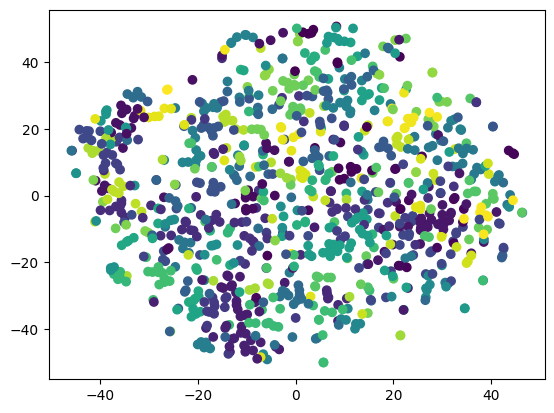

In [179]:
tnse = TSNE(n_components=2, random_state=42)
tnse_relust = tnse.fit_transform(nratingspd)
plt.scatter(tnse_relust[:, 0], tnse_relust[:, 1], c=clusters)

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

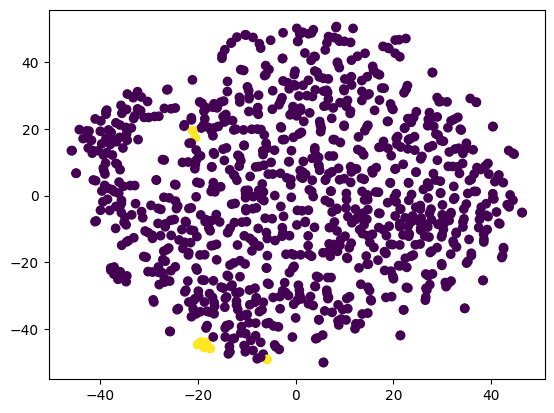

In [180]:
plt.scatter(tnse_relust[:, 0], tnse_relust[:, 1], c=(clusters == 42))

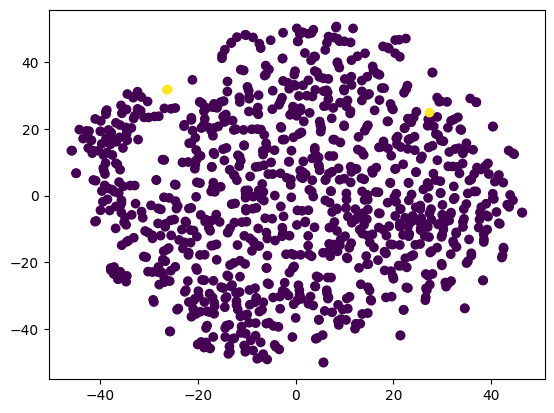

In [186]:
plt.scatter(tnse_relust[:, 0], tnse_relust[:, 1], c=(clusters == 99))

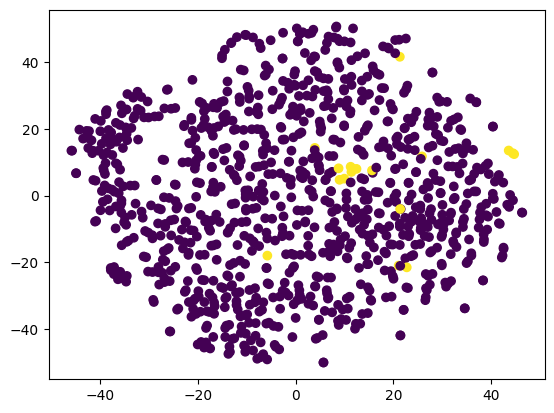

In [187]:
plt.scatter(tnse_relust[:, 0], tnse_relust[:, 1], c=(clusters == 1))

**Ответ:** Получается достаточно плохо для каких-то случайно выбранных признаков